## SRGAN을 활용한 이미지 개선
### 생성자(generator)
- 이미지로부터 특징 추출 -> 해상도를 높여 출력
- 감별자를 속이고, CNN에 의한 이미지 특징 차이가 작아지도록 학습
### 감별자(discriminator)
- 실제의 이미지와 생성자가 만들어낸 이미지를 구별하도록 학습

In [1]:
import tqdm
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
import glob
import torchvision.transforms as tf
from torch.utils.data.dataset import Dataset
from PIL import Image
from model.srGan import Generator, Discriminator

c:\Users\seung\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Utils

In [3]:
class CelebA(Dataset):
  def __init__(self):
    self.imgs = glob.glob("./data/gan/*.jpg")
    mean_std = (0.5, 0.5, 0.5)
    self.low_res_tf = tf.Compose([
        tf.Resize((32, 32)),
        tf.ToTensor(),
        tf.Normalize(mean_std, mean_std)
    ])
    self.high_res_tf = tf.Compose([
        tf.Resize((64, 64)),
        tf.ToTensor(),
        tf.Normalize(mean_std, mean_std)
    ])
  
  def __len__(self):
    return len(self.imgs)
  def __getitem__(self, i):
    img = Image.open(self.imgs[i])
    img_low_res = self.low_res_tf(img)
    img_high_res = self.high_res_tf(img)
    return [img_low_res, img_high_res]

from torchvision.models.vgg import vgg19

class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    vgg19_model = vgg19(pretrained=True)

    self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:9])
  
  def forward(self, img):
    return self.feature_extractor(img)

#### 학습

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = CelebA()
batch_size = 8
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = Generator().to(device)
D = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

for epoch in range(1):
  iterator = tqdm.tqdm(loader)
  for i, (low_res, high_res) in enumerate(iterator):
    G_optim.zero_grad()
    D_optim.zero_grad()

    label_true = torch.ones(batch_size, dtype=torch.float32).to(device)
    label_false = torch.zeros(batch_size, dtype=torch.float32).to(device)

    fake_hr = G(low_res.to(device))
    GAN_loss = nn.MSELoss()(D(fake_hr), label_true)

    fake_features = feature_extractor(fake_hr)
    real_features = feature_extractor(high_res.to(device))
    content_loss = nn.L1Loss()(fake_features, real_features)

    loss_G = content_loss + 0.001*GAN_loss
    loss_G.backward()
    G_optim.step()

    real_loss = nn.MSELoss()(D(high_res.to(device)), label_true)
    fake_loss = nn.MSELoss()(D(fake_hr.detach()), label_false)

    loss_D = (real_loss + fake_loss) / 2
    loss_D.backward()
    D_optim.step()
    
    iterator.set_description(f"epoch:{epoch} G_loss:{GAN_loss} D_loss:{loss_D}")

torch.save(G.state_dict(), "./data/weights/SRGAN_G.pth")
torch.save(D.state_dict(), "./data/weights/SRGAN_D.pth")

hi


c:\Users\seung\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\seung\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/13 [00:00<?, ?it/s]c:\Users\seung\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduc

#### 평가

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


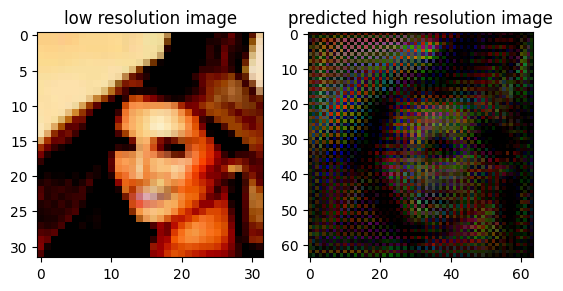

In [6]:
import matplotlib.pyplot as plt

G.load_state_dict(torch.load("./data/weights/SRGAN_G.pth", map_location=device))
with torch.no_grad():
  low_res, high_res = dataset[0]
  input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
  pred = G(input_tensor)
  pred = pred.squeeze()
  pred = pred.permute(1, 2, 0).cpu().numpy()
  low_res = low_res.permute(1, 2, 0).numpy()
  plt.subplot(1, 2, 1)
  plt.title("low resolution image")
  plt.imshow(low_res)
  plt.subplot(1, 2, 2)
  plt.imshow(pred)
  plt.title("predicted high resolution image")
  plt.show()